*The objective of this notebook is to show how GCM closures can be tuned in practice. We will assume a specific formulation of a closure and estimate its parameters through a standard optimisation procedure with DA.*

**Resources** : We have used material from Emmanuel Cosme's nice GitHub repos : https://github.com/ecosme38/Data-Assimilation-Notebooks 

## 1. Copy / pasting from gcm-parameterization-problem notebook 

Starting from `gcm-parameterization-problem`

In [1]:
from L96_model import L96, L96_eq1_xdot  
# L96 provides the "real world", L96_eq1_xdot is the beginning of rhs of X tendency
from L96_model import EulerFwd, RK2, RK4 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setting the seed gives us reproducible results
np.random.seed(13)

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=18)

# Run "real world" for 3 days to forget initial conditons
# (store=True save the final state as an initial condition for the next run)
W.run(0.05, 3., store=True);

# From here on we can use W.X as perfect initial conditions for a model 
# and sample the real world using W.run(dt,T)

In [3]:
class GCM:
    def __init__(self, F, parameterization, time_stepping=EulerFwd):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        return L96_eq1_xdot(X, self.F) -  self.parameterization(param,X)
        
    def __call__(self,X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X,param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [4]:
# As a first step, we illustrate introducing a polynomial parameterization to GCM
naive_parameterization= lambda param,X : np.polyval(param,X)
F, dt, T = 18, 0.01, 5.
gcm = GCM (F,naive_parameterization)
X,t = gcm(W.X,dt, int(T/dt), param=[0.85439536, 1.75218026])

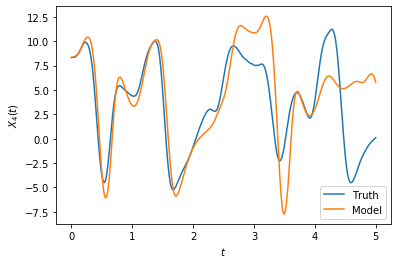

In [5]:
# Comparing model and true trajectories. 

# This samples the real world with the same time interval as "dt" used by the model
Xtrue,_,_ = W.run(dt, T)

plt.plot(t, Xtrue[:,4], label='Truth');
plt.plot(t, X[:,4], label='Model');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

We also copy the distance metrics used in the gcm-parameterization-problem notebook 

In [6]:
#- pointwise distance : 
def pointwise(X1,X2,L=1.): # computed over some window t<L. 
    D = (X1-X2)[np.where(t<L)]
    return np.sqrt(D**2).mean(axis=0)

In [7]:
#- mean state metric : 
def dist_mean(X1,X2,L=1.):
    _X1 = X1[np.where(t<L)]
    _X2 = X2[np.where(t<L)]
    return np.sqrt((_X1.mean(axis=0)-_X2.mean(axis=0))**2)

In [8]:
def norm_initial_tendency(X1,X2): 
    T1 = X1[1,:] - X1[0,:]
    T2 = X2[1,:] - X2[0,:]
    return np.sqrt((T1-T2)**2).mean(axis=0)

## 2. Variational estimation of optimal parameters for a predefined closure

We will try here to estimate the parameters of `naive_parameterization` with a variational approach. 

In [9]:
#- assuming the formulation of the parameterization
gcm = GCM (F,naive_parameterization)

### 2.1 Estimating parameters based on one initial condition and one time step

#### Cost function 

What we will be doing here is very close to what is done with classical variational data assimilation, where people try to estimate the state of the parameters of a model through the minimization of a cost function $J$. This is also very close to what is done when parameterizations are encoded as neural network. 

We introduce a cost function $J(p)$ which depends on the parameters of the closure. 

$$J(p) = ||X_p - X_{true}||_{d}$$

where $p=[p1,p2]$, $X_p$ is GCM solution computed with with parameters $p$ and $||\cdot ||_{d}$ is one of the distances above. 


In [10]:
def cost_function(param):
    F, dt, T = 18, 0.01, 0.01
    Xgcm,t = gcm(W.X,dt, int(T/dt), param=param)
    return norm_initial_tendency(Xtrue,Xgcm) 

#### Minimization 

The problem dimension being small enough (2 parameters to find), one can use efficient derivative-free optimization methods.


In [11]:
import scipy.optimize as opt

prior = np.array([0.85439536, 1.75218026])  #  prior
res = opt.minimize(cost_function,prior, method='Powell')
opt_param = res['x']

In [12]:
opt_param

array([ 1.19227681, -0.19543572])

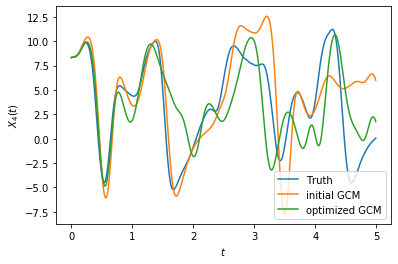

In [13]:
#- Let's test our closure 
F, dt, T = 18, 0.01, 100.
gcm = GCM (F,naive_parameterization)
Xopti,t = gcm(W.X,dt, int(T/dt), param=opt_param)
Xprior,t = gcm(W.X,dt, int(T/dt), param=prior)

#- ... the true state  
Xtrue,_,_ = W.run(dt, T)

## and plot the results  
plt.plot(t[:500], Xtrue[:500,4], label='Truth');
plt.plot(t[:500], Xprior[:500,4], label='initial GCM');
plt.plot(t[:500], Xopti[:500,4], label='optimized GCM');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

This is better but not great... This problem is related to the question of *a priori* versus *a posteriori* skill in LES closures.

### 2.2 Estimating parameters which optimize longer trajectories

In [14]:
F, dt, T = 18, 0.01, 5.
gcm = GCM (F,naive_parameterization)
Xtrue,_,_ = W.run(dt, T)


In [15]:
Xgcm,t = gcm(W.X,dt, int(T/dt), param=[0,0])

/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [16]:
def cost_function(param):
    F, dt, T = 18, 0.01, 5
    Xgcm,t = gcm(W.X,dt, int(T/dt), param=param)
    return pointwise(Xtrue,Xgcm,L=5.).sum()

In [17]:
prior = np.array([0.85439536, 1.75218026])  #  prior
res = opt.minimize(cost_function,prior, method='Powell')
opt_param = res['x']

/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


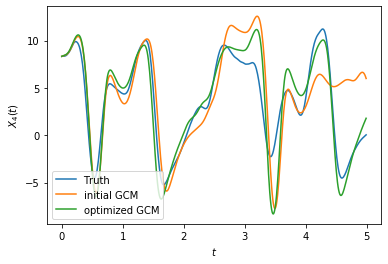

In [19]:
#- Let's test our closure 
F, dt, T = 18, 0.01, 100.
gcm = GCM (F,naive_parameterization)
Xopti,t = gcm(W.X,dt, int(T/dt), param=opt_param)
Xprior,t = gcm(W.X,dt, int(T/dt), param=prior)

#- ... the true state  
Xtrue,_,_ = W.run(dt, T)

## and plot the results  
plt.plot(t[:500], Xtrue[:500,4], label='Truth');
plt.plot(t[:500], Xprior[:500,4], label='initial GCM');
plt.plot(t[:500], Xopti[:500,4], label='optimized GCM');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

This is better but it is not clear how this would generalize to unseen initial conditions. 

## 3. Next steps and thoughts

### 3.1 Possible next steps

 - Estimating parameters over one time-step but with an ensemble of initial conditions. 
 - Encode the closure with neural networks.


### 3.2 Discussion topics

 - The need for differentiable gcm. 
 - ...